In [1]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

!pip install -q -U opencv-python


In [2]:
from matplotlib.patches import Circle


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#DATA

##img

In [111]:
path ='/content/drive/MyDrive/Colab Notebooks/MY_OWN_CV_MODEL/new_dataset/augmented_data/separated_data/img'

In [112]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [113]:
train_images = tf.data.Dataset.list_files(path+'/train/*jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [114]:
test_images = tf.data.Dataset.list_files(path+'/test/*jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [115]:
val_images = tf.data.Dataset.list_files(path+'/val/*jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

##labels

In [101]:
l_path = '/content/drive/MyDrive/Colab Notebooks/MY_OWN_CV_MODEL/new_dataset/augmented_data/separated_data/labels'

In [102]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

        lista=[]
        lista.append(label['keypoints']['0'] / 250)
        lista.append(label['keypoints']['1'] / 250)
        lista.append(label['keypoints']['2'] / 250)
        lista.append(label['keypoints']['3'] / 250)
        lista

    return [lista]



In [103]:
train_labels = tf.data.Dataset.list_files(l_path+'/train/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [104]:
test_labels = tf.data.Dataset.list_files(l_path+'/test/*json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [105]:
val_labels = tf.data.Dataset.list_files(l_path+'/val/*json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))


In [106]:
with open(l_path+'/train/'+'1.json', "r") as read_it:
     data = json.load(read_it)

lista=[]
lista.append(data['keypoints']['0'])
lista.append(data['keypoints']['1'])
lista.append(data['keypoints']['2'])
lista.append(data['keypoints']['3'])
lista

[136, 97, 112, 95]

In [107]:
iterator=val_labels.as_numpy_iterator()
iterator.next()

(array([0.52 , 0.34 , 0.592, 0.384], dtype=float16),)

##combine labels and img

In [116]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [117]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [118]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

#TRAIN

In [119]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()


##Build Model

In [120]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,)),
    tf.keras.layers.Dense(4, activation = "gelu")
])

In [121]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_22 (Conv2D)          (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 2, 256)         262400    
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 1, 1, 4)          

In [122]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer, loss)


In [123]:
hist = model.fit(train, epochs=5, validation_data=val)


Epoch 1/5
9/9 [==============================] - 26s 905ms/step - loss: 2.4032 - val_loss: 132.5279
Epoch 2/5
9/9 [==============================] - 5s 519ms/step - loss: 0.1481 - val_loss: 4628094.0000
Epoch 3/5
9/9 [==============================] - 5s 520ms/step - loss: 0.1230 - val_loss: 12166592.0000
Epoch 4/5
9/9 [==============================] - 5s 523ms/step - loss: 0.1233 - val_loss: 1217742.8750
Epoch 5/5
9/9 [==============================] - 5s 527ms/step - loss: 0.1228 - val_loss: 24825.9570


In [124]:
hist.history


{'loss': [2.403240203857422,
  0.14805398881435394,
  0.12300344556570053,
  0.12327881902456284,
  0.12282808870077133],
 'val_loss': [132.5279083251953,
  4628094.0,
  12166592.0,
  1217742.875,
  24825.95703125]}

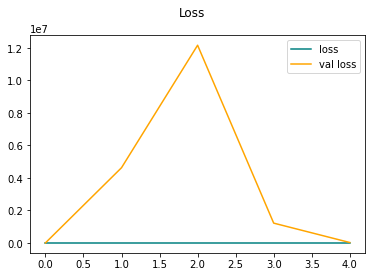

In [125]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

In [126]:
test_data = train.as_numpy_iterator()
test_sample = test_data.next()


In [127]:
yhat = model.predict(test_sample[0])


1/1 [==============================] - 3s 3s/step


In [128]:
ghat= yhat.copy() 
ghat

array([[ -0.      , 134.7168  , 124.16998 , 150.84949 ],
       [ -0.      , 168.07866 , 176.79172 , 197.0753  ],
       [ -0.      , 192.42093 , 199.22504 , 195.81615 ],
       [ -0.      , 131.80797 , 127.90807 , 144.83542 ],
       [ -0.      , 192.27483 , 207.20995 , 223.70073 ],
       [ -0.      , 121.21353 , 107.78154 , 142.5187  ],
       [ -0.      , 123.69748 , 114.997025, 145.55894 ],
       [ -0.      , 217.73242 , 206.94724 , 243.91444 ],
       [ -0.      , 179.6235  , 193.73965 , 208.21535 ],
       [ -0.      , 198.27097 , 197.14561 , 223.31276 ],
       [ -0.      , 145.49605 , 143.05289 , 164.19826 ],
       [ -0.      , 129.30908 , 119.62532 , 143.04668 ],
       [ -0.      , 161.68779 , 152.47485 , 185.68956 ],
       [ -0.      , 121.7986  , 119.8807  , 128.9594  ],
       [ -0.      , 114.50247 , 101.66169 , 132.0028  ],
       [ -0.      , 160.82112 , 168.02937 , 183.78986 ]], dtype=float32)

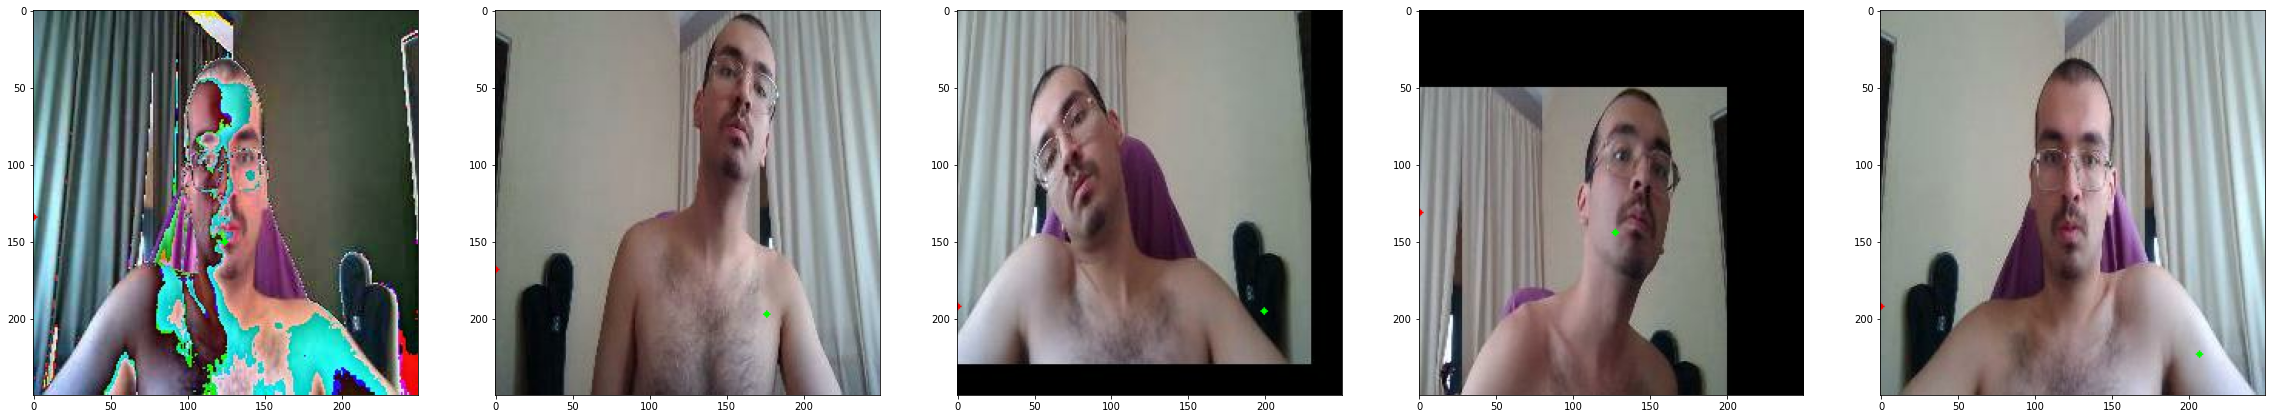

In [129]:
fig, ax = plt.subplots(ncols=5, figsize=(40,40))
for idx in range(5): 
    sample_image = test_sample[0][idx]
    sample_coords = ghat[idx] 
    
    a=tuple(sample_coords[:2].astype(int))
    b=tuple(sample_coords[2:].astype(int))

    cv2.circle(sample_image, a , 2, (255,0,0), -1)
    cv2.circle(sample_image, b , 2, (0,255,0), -1)

    ax[idx].imshow(sample_image)


In [130]:
#show image and coords function
def show_img_and_eyes(img, coords=None):
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')



    ax.imshow(img)
    if(coords is not None):
      a=tuple(coords[:2])
      b=tuple(coords[2:])
      circ = Circle(a,6)
      circ2 = Circle(b,6)

      ax.add_patch(circ)
      ax.add_patch(circ2)

    return plt.show()

In [131]:
for idx in range(4): 
    sample_coords = ghat[idx]
    
    tuple(np.multiply(sample_coords[:2], [250,250]).astype(int))
    tuple(np.multiply(sample_coords[2:], [250,250]).astype(int))

    a=tuple(sample_coords[:2].astype(int))
    b=tuple(sample_coords[2:].astype(int))
    print(a,b)

(0, 134) (124, 150)
(0, 168) (176, 197)
(0, 192) (199, 195)
(0, 131) (127, 144)
